In [41]:
project_id = 'd3e50ab2-8235-4011-a8dc-15077cb87e57' # Replace with your project ID
cv_key = '2819396149644c6197cd6526f39d54ba' # Replace with your prediction resource primary key
cv_endpoint = 'https://clothdefects-prediction.cognitiveservices.azure.com/' # Replace with your prediction resource endpoint

model_name = 'Iteration2_cloth_prediction' # this must match the model name you set when publishing your model iteration exactly (including case)!
print('Ready to predict using model {} in project {}'.format(model_name, project_id))

Ready to predict using model Iteration2_cloth_prediction in project d3e50ab2-8235-4011-a8dc-15077cb87e57


In [42]:
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from msrest.authentication import ApiKeyCredentials
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import os
%matplotlib inline

Detecting defects in test_image.png using model Iteration2_cloth_prediction in project d3e50ab2-8235-4011-a8dc-15077cb87e57...
63.15734528 82.6708625 22.366405 380.032896


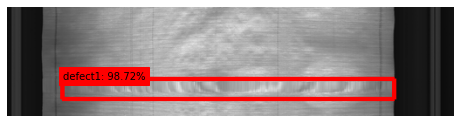

In [43]:
# Load a test image and get its dimensions
test_img_file = os.path.join('test_image.png')
test_img = Image.open(test_img_file)
test_img_h, test_img_w, test_img_ch = np.array(test_img).shape

# Get a prediction client for the object detection model
credentials = ApiKeyCredentials(in_headers={"Prediction-key": cv_key})
predictor = CustomVisionPredictionClient(endpoint=cv_endpoint, credentials=credentials)

print('Detecting defects in {} using model {} in project {}...'.format(test_img_file, model_name, project_id))

# Detect objects in the test image
with open(test_img_file, mode="rb") as test_data:
    results = predictor.detect_image(project_id, model_name, test_data)

# Create a figure to display the results
fig = plt.figure(figsize=(8, 8))
plt.axis('off')

# Display the image with boxes around each detected object
draw = ImageDraw.Draw(test_img)
lineWidth = int(np.array(test_img).shape[1]/100)
object_colors = {
    "defect1": "red",
    "defect2": "yellow",
}

for prediction in results.predictions:
    color = 'white' # default for 'other' object tags
    if (prediction.probability*100) > 30:
        if prediction.tag_name in object_colors:
            color = object_colors[prediction.tag_name]
        left = prediction.bounding_box.left * test_img_w 
        top = prediction.bounding_box.top * test_img_h 
        height = prediction.bounding_box.height * test_img_h
        width =  prediction.bounding_box.width * test_img_w
        points = ((left,top), (left+width,top), (left+width,top+height), (left,top+height),(left,top))
        draw.line(points, fill=color, width=lineWidth)
        plt.annotate(prediction.tag_name + ": {0:.2f}%".format(prediction.probability * 100),(left,top), backgroundcolor=color)
plt.imshow(test_img)

print(left, top, height, width)

In [44]:
# Now there is a trained endpoint that can be used to make a prediction
prediction_key = '2819396149644c6197cd6526f39d54ba'
prediction_credentials = ApiKeyCredentials(in_headers={"Prediction-key": prediction_key})
ENDPOINT2 = "https://clothdefects-prediction.cognitiveservices.azure.com/"
predictor = CustomVisionPredictionClient(ENDPOINT2, prediction_credentials)

# # Open the sample image and get back the prediction results.
# with open(os.path.join ("test_image.png"), mode="rb") as test_data:
#     results = predictor.detect_image(project_id, model_name, test_data)

# # Display the results.
# for prediction in results.predictions:
#     print("\t" + prediction.tag_name + ": {0:.2f}% x = {1:.2f}, y = {2:.2f}, w = {3:.2f}, h = {4:.2f}".format(prediction.probability * 100, prediction.bounding_box.left + prediction.bounding_box.width/2, prediction.bounding_box.top + prediction.bounding_box.height/2, prediction.bounding_box.width, prediction.bounding_box.height))

In [46]:
import pandas as pd

DefectType_df = pd.read_csv("Final_DefectType_Error303.csv")
DefectType_df = DefectType_df[DefectType_df["defect_flag"] == 1].reset_index(drop=True)

image_id, X, Y, W, H = [], [], [], [], []

for file in os.listdir('test_images/New_Images'):
    # Opening the image and get back the prediction results.
    if str(file) in list(DefectType_df["images id"]):
        with open(os.path.join('test_images/New_Images', file), mode="rb") as test_data:
            results = predictor.detect_image(project_id, model_name, test_data)
    
        prediction = results.predictions[0]
        print("\t" + "Image {}  ".format(str(file)) + prediction.tag_name + ": {0:.2f}% x = {1:.2f}, y = {2:.2f}, w = {3:.2f}, h = {4:.2f}".format(prediction.probability * 100, prediction.bounding_box.left + prediction.bounding_box.width/2, prediction.bounding_box.top + prediction.bounding_box.height/2, prediction.bounding_box.width, prediction.bounding_box.height))
        image_id.append(str(file))
        X.append(prediction.bounding_box.left + prediction.bounding_box.width/2)
        Y.append(prediction.bounding_box.top + prediction.bounding_box.height/2)
        W.append(prediction.bounding_box.width)
        H.append(prediction.bounding_box.height)


df = pd.DataFrame({'  image_id':image_id, 'X':X, 'Y':Y, 'W':W, 'H':H})
df.to_csv('Final_DefectBoxes_Error303_3.csv', index=False)

	Image 000001.png  defect1: 94.70% x = 0.50, y = 0.05, w = 0.61, h = 0.08
	Image 000004.png  defect1: 19.78% x = 0.50, y = 0.86, w = 0.71, h = 0.11
	Image 000005.png  defect1: 85.78% x = 0.49, y = 0.57, w = 0.61, h = 0.13
	Image 000006.png  defect1: 9.02% x = 0.49, y = 0.09, w = 0.65, h = 0.10
	Image 000009.png  defect1: 54.72% x = 0.49, y = 0.08, w = 0.67, h = 0.13
	Image 000010.png  defect1: 99.29% x = 0.49, y = 0.08, w = 0.68, h = 0.13
	Image 000013.png  defect1: 57.05% x = 0.50, y = 0.83, w = 0.70, h = 0.13
	Image 000014.png  defect1: 91.76% x = 0.49, y = 0.67, w = 0.63, h = 0.12
	Image 000015.png  defect1: 18.80% x = 0.49, y = 0.80, w = 0.66, h = 0.13
	Image 000018.png  defect1: 19.12% x = 0.49, y = 0.82, w = 0.68, h = 0.13
	Image 000019.png  defect1: 70.70% x = 0.50, y = 0.20, w = 0.65, h = 0.16
	Image 000023.png  defect1: 94.74% x = 0.48, y = 0.71, w = 0.55, h = 0.10
	Image 000028.png  defect1: 77.46% x = 0.50, y = 0.13, w = 0.70, h = 0.15
	Image 000029.png  defect1: 58.74% x = 